In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [2]:
def matplotlib_visualize_splines(points: np.ndarray, line_label: str, points_label: str, is_loop: bool = False):
    if is_loop:
        points = np.vstack([points, points[0]])
    
    # Define the parametric points (x and y coordinates)
    t_points = np.arange(points.shape[0])
    x_points = np.array(points[:, 0])
    y_points = np.array(points[:, 1])

    # Create parametric cubic splines for x(t) and y(t)
    bc_type = 'periodic' if is_loop else 'not-a-knot'
    spline_x = CubicSpline(t_points, x_points, bc_type=bc_type)
    spline_y = CubicSpline(t_points, y_points, bc_type=bc_type)

    # Generate values of t for plotting the spline
    t_fine = np.linspace(t_points[0], t_points[-1], 100)

    # Evaluate the splines to get the points on the curve
    x_fine = spline_x(t_fine)
    y_fine = spline_y(t_fine)

    # Plot the parametric spline
    plt.plot(x_fine, y_fine, label=line_label)
    plt.plot(x_points, y_points, 'o', label=points_label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure the x and y axes have the same scale


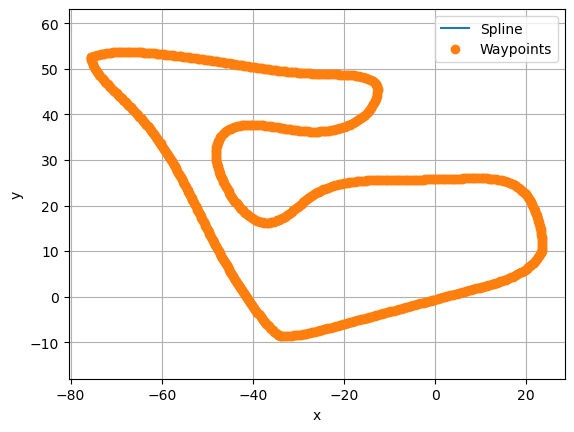

(863, 2)


In [3]:
import pandas
waypoints_csv = pandas.read_csv('../../Spielberg_waypoints.csv')
from matrices_jax import *
points = waypoints_csv.values
matplotlib_visualize_splines(points, 'Spline', 'Waypoints', is_loop=True)
plt.show()
print(points.shape)

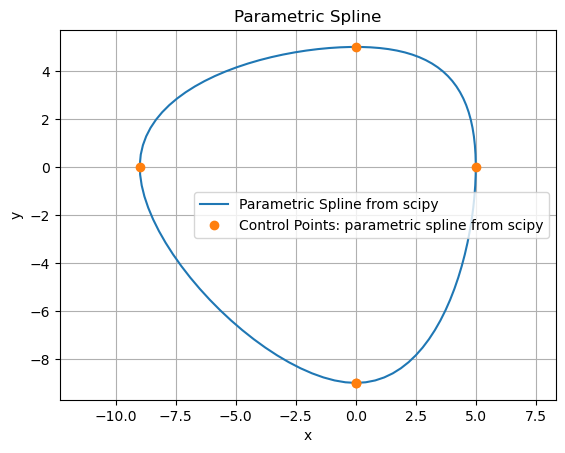

In [4]:


nx1, ny1 = 0, -1
nx2 , ny2 = 1, 0
nx3, ny3 = 0, 1
nx4, ny4 = -1, 0

x1, y1 = 0, -9

x2, y2 = 5, 0

x3, y3 = 0, 5

x4, y4 = -9, 0

points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=np.float64)
plt.title('Parametric Spline')
matplotlib_visualize_splines(points, 'Parametric Spline from scipy', 'Control Points: parametric spline from scipy', True)
plt.show()

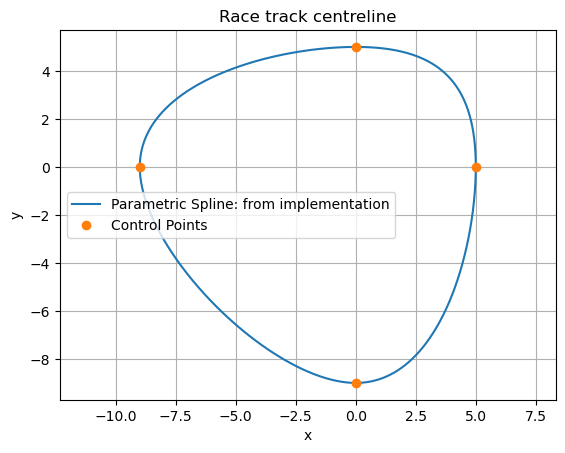

In [5]:
from perception_data import Centreline

centreline = Centreline(points.shape[0], points, 0.5*np.ones(points.shape[0]), 0.2)

def coords(t, a, b, c, d):
    t_floor = np.int32(t)
    t_frac = t - t_floor
    return np.array([ (a[I] + b[I]*f + c[I]*f**2 + d[I]*f**3) for i in range(t.shape[0]) if (I := (t_floor[i])%(a.shape[0]), f := t_frac[i]) ])

def implemented_visualize_splines(points: np.ndarray, line_label: str, points_label: str, show_control_points: bool = False, dashed: bool = False):
    Ainv = matAInv(points.shape[0])
    centreline = Centreline(points.shape[0], points, 0, 0) # vehicle width and track width are not used in the function
    abcd_x = (Ainv @ q_comp(centreline, 0)).reshape((-1, 4))
    abcd_y = (Ainv @ q_comp(centreline, 1)).reshape((-1, 4))

    # Define the parametric points (x and y coordinates)
    t_points = np.arange(points.shape[0])
    x_points = np.array(points[:, 0])
    y_points = np.array(points[:, 1])

    # Generate values of t for plotting the spline
    t_fine = np.linspace(t_points[0], t_points[-1] + 1, 1000)

    # Evaluate the splines to get the points on the curve
    x_fine = coords(t_fine, abcd_x[:, 0], abcd_x[:, 1], abcd_x[:, 2], abcd_x[:, 3])
    y_fine = coords(t_fine, abcd_y[:, 0], abcd_y[:, 1], abcd_y[:, 2], abcd_y[:, 3])

    # Plot the parametric spline
    if dashed: plt.plot(x_fine, y_fine, '--', label=line_label)
    else: plt.plot(x_fine, y_fine, label=line_label)
    if show_control_points: plt.plot(x_points, y_points, 'o', label=points_label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensure the x and y axes have the same scale

plt.title('Race track centreline')
implemented_visualize_splines(centreline.p, 'Parametric Spline: from implementation', 'Control Points', True)
plt.show()

In [6]:
import cvxpy as cp

In [12]:
from solve_qp import solve_for_alpha

alpha = solve_for_alpha(centreline)

In [13]:
def points_raceline(centreline: Centreline, alpha: np.ndarray):
    return centreline.p + centreline.n * jnp.repeat(alpha, 2, axis=0).reshape((-1, 2))

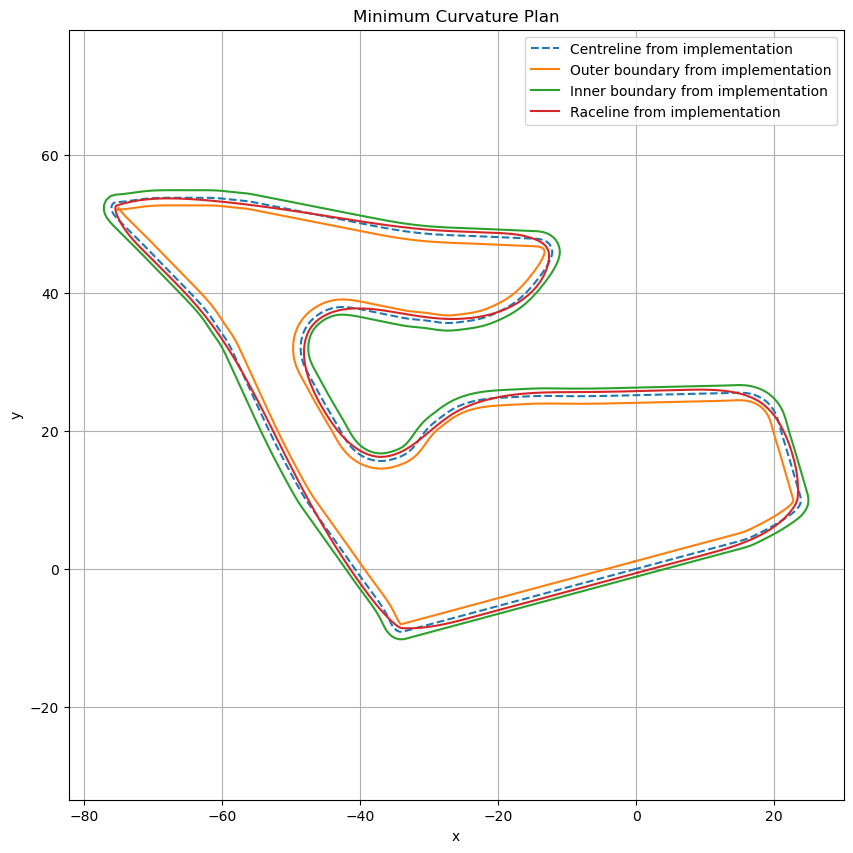

In [14]:
def visualize_solution(centreline: Centreline, points_raceline: np.ndarray):
    plt.figure(figsize=(10, 10))
    plt.title('Minimum Curvature Plan')
    points_centreline = centreline.p
    points_boundary_max = centreline.p + centreline.n * np.repeat(centreline.half_w_tr, 2, axis=0).reshape((-1, 2)) 
    points_boundary_min = centreline.p - centreline.n * np.repeat(centreline.half_w_tr, 2, axis=0).reshape((-1, 2)) 
    # matplotlib_visualize_splines(points_centreline, True)
    # matplotlib_visualize_splines(points_boundary_max, 'Outer boundary from scipy', 'Control Points: Outer boundary from scipy', True)
    # matplotlib_visualize_splines(points_boundary_min, 'Inner boundary from scipy', 'Control Points: Inner boundary from scipy', True)
    # matplotlib_visualize_splines(points_raceline, 'Raceline from scipy', 'Control Points: Raceline from scipy', True)
    implemented_visualize_splines(points_centreline, 'Centreline from implementation', 'Control Points: Centreline from implementation', dashed=True)
    implemented_visualize_splines(points_boundary_max, 'Outer boundary from implementation', 'Control Points: Outer boundary from implementation')
    implemented_visualize_splines(points_boundary_min, 'Inner boundary from implementation', 'Control Points: Inner boundary from implementation')
    implemented_visualize_splines(points_raceline, 'Raceline from implementation', 'Control Points: Raceline from implementation')
    plt.show()

visualize_solution(centreline, points_raceline(centreline, alpha))

In [15]:
from export_solution import export_solution

export_solution(points_raceline(centreline, alpha), 'waypoints3.json', format='json')

In [16]:
from csv_reader import centreline_from_csv

centreline = centreline_from_csv(1.0, '../../maps/Spielberg_centerline.csv')
# centreline = centreline_from_csv(1.0, '../../maps/Budapest_centerline.csv')

# Run the last 4 cells again to visualize the raceline and export the waypoints to a json file